# Evaluate melt rates (circumpolar and Amundsen Sea)

In [11]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import sys
sys.path.append('/home/users/birgal/')
from nemo_python_git.plots import circumpolar_plot
from nemo_python_git.constants import rho_ice, sec_per_year, sec_per_day, line_colours, cesm2_ensemble_members
from nemo_python_git.grid import region_mask
from nemo_python_git.projects.eANT025 import plot_annual_melt_overview

In [12]:
base_dir = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'
# run_folder    = f'{base_dir}output/getz_shallow/files1/'
# run_folder    = f'{base_dir}output/ERA5_1h_tune0_efr005/files1/'
run_folder    = f'{base_dir}output/CESM2_3hwind_1979_test1_winds/files0/'
nemo_mesh     = f'{base_dir}bathymetry/mesh_mask-20250715.nc'
nemo_domain   = f'{base_dir}bathymetry/domain_cfg-20250715.nc'

In [3]:
def mask_land(nemo_mesh, file_var):
    mask = (nemo_mesh.tmask.isel(nav_lev=0) != 0) | (nemo_mesh.misf == 0)
    lon_plot = np.ma.masked_where(mask, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(mask, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(mask, file_var.values)
    return lon_plot, lat_plot, plot_var 

def plot_land(nemo_mesh, file_var):
    mask = (nemo_mesh.misf!=0) 
    lon_plot = np.ma.masked_where(mask, nemo_mesh.nav_lon.values)
    lat_plot = np.ma.masked_where(mask, nemo_mesh.nav_lat.values)
    plot_var = np.ma.masked_where(mask, file_var.values)
    return lon_plot, lat_plot, plot_var

## Ice shelf melt rates

In [4]:
nemo_mesh_ds = xr.open_dataset(nemo_mesh).isel(time_counter=0)
mesh_sub  = nemo_mesh_ds.isel(x=slice(450, 900), y=slice(130,350))

#### Amundsen Sea

In [6]:
from calendar import monthrange

# load nemo simulations
gridT_files = glob.glob(f'{run_folder}*SBC*')
nemo_ds     = xr.open_mfdataset(gridT_files) # load all the gridT files in the run folder
# nemo_ds   = xr.open_dataset(gridT_files[0])
days_per_month = [monthrange(nemo_ds.time_counter.dt.year[i].values, nemo_ds.time_counter.dt.month[i].values)[1] for i in range(0,nemo_ds.time_counter.size)]
nemo_ds   = nemo_ds.assign({'days_per_month':(('time_counter'), days_per_month)})
melt_rate = ((nemo_ds.fwfisf)*nemo_ds['days_per_month']*sec_per_day).sum(dim='time_counter')/(rho_ice*len(np.unique(nemo_ds.time_counter.dt.year)))

In [9]:
melt_rate_sub = melt_rate.isel(x_grid_T=slice(450, 900), y_grid_T=slice(130,350))

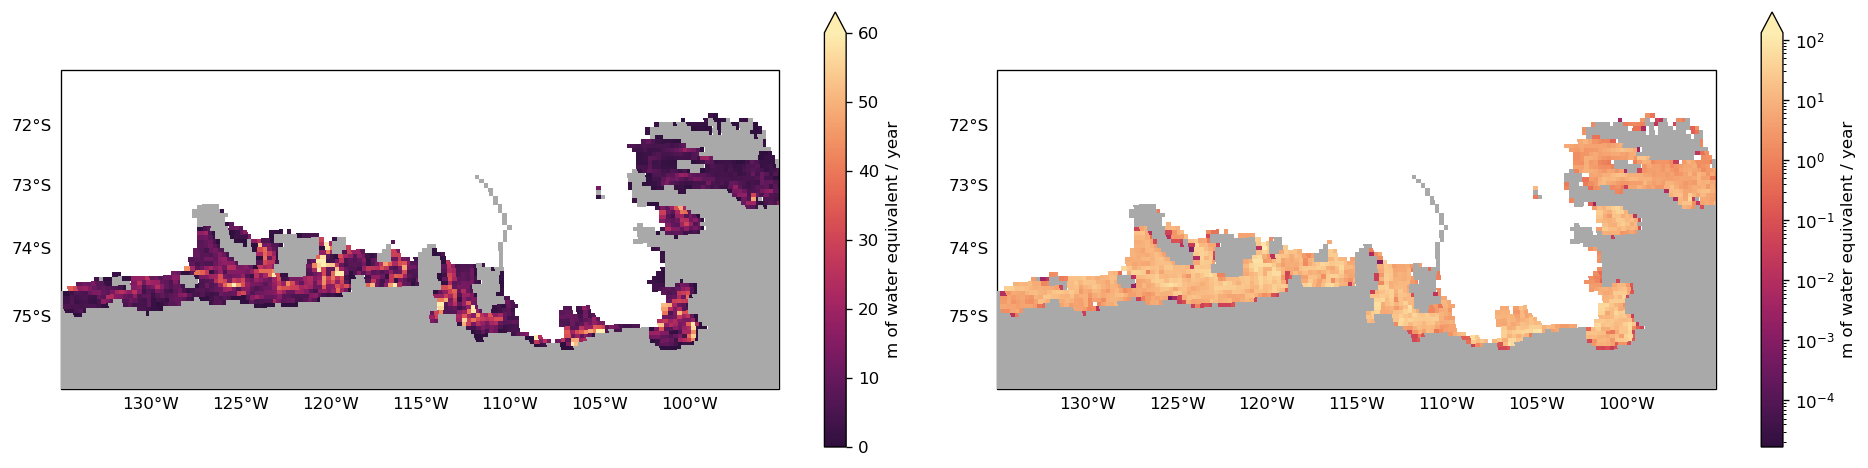

In [11]:
# Check that the observations depth is close enough to the bottom bathymetry to be considered representative

# Select the NEMO variables we need and time-average    
lon_land, lat_land, land_plt = plot_land(mesh_sub, mesh_sub.bathy_metry)

#------------- Plot figure -----------------
fig, ax = plt.subplots(1,2, figsize=(16,4), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=120)

lon_plt, lat_plt, var_plt = mask_land(mesh_sub, melt_rate_sub)
img1 = ax[0].pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, 
                     vmin=0, vmax=60, cmap=cmocean.cm.matter_r)

img2 = ax[1].pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, 
                    cmap=cmocean.cm.matter_r, norm=cl.LogNorm())
img = [img1, img2]
for n, axis in enumerate(ax.ravel()):
    axis.set_extent([-95, -135, -76, -71], ccrs.PlateCarree())
    gl = axis.gridlines(draw_labels=True);
    gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

    axis.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, 
              cmap=cl.ListedColormap(['DarkGrey']), zorder=3)
    
    plt.colorbar(img[n], ax=axis, extend='max', label='m of water equivalent / year')

plt.tight_layout()

## Circumpolar Antarctic

vmin and vmax must be positive and non-zero when using a logarithmic colormap (lognorm=True), so allowing pcolormesh to choose limits instead


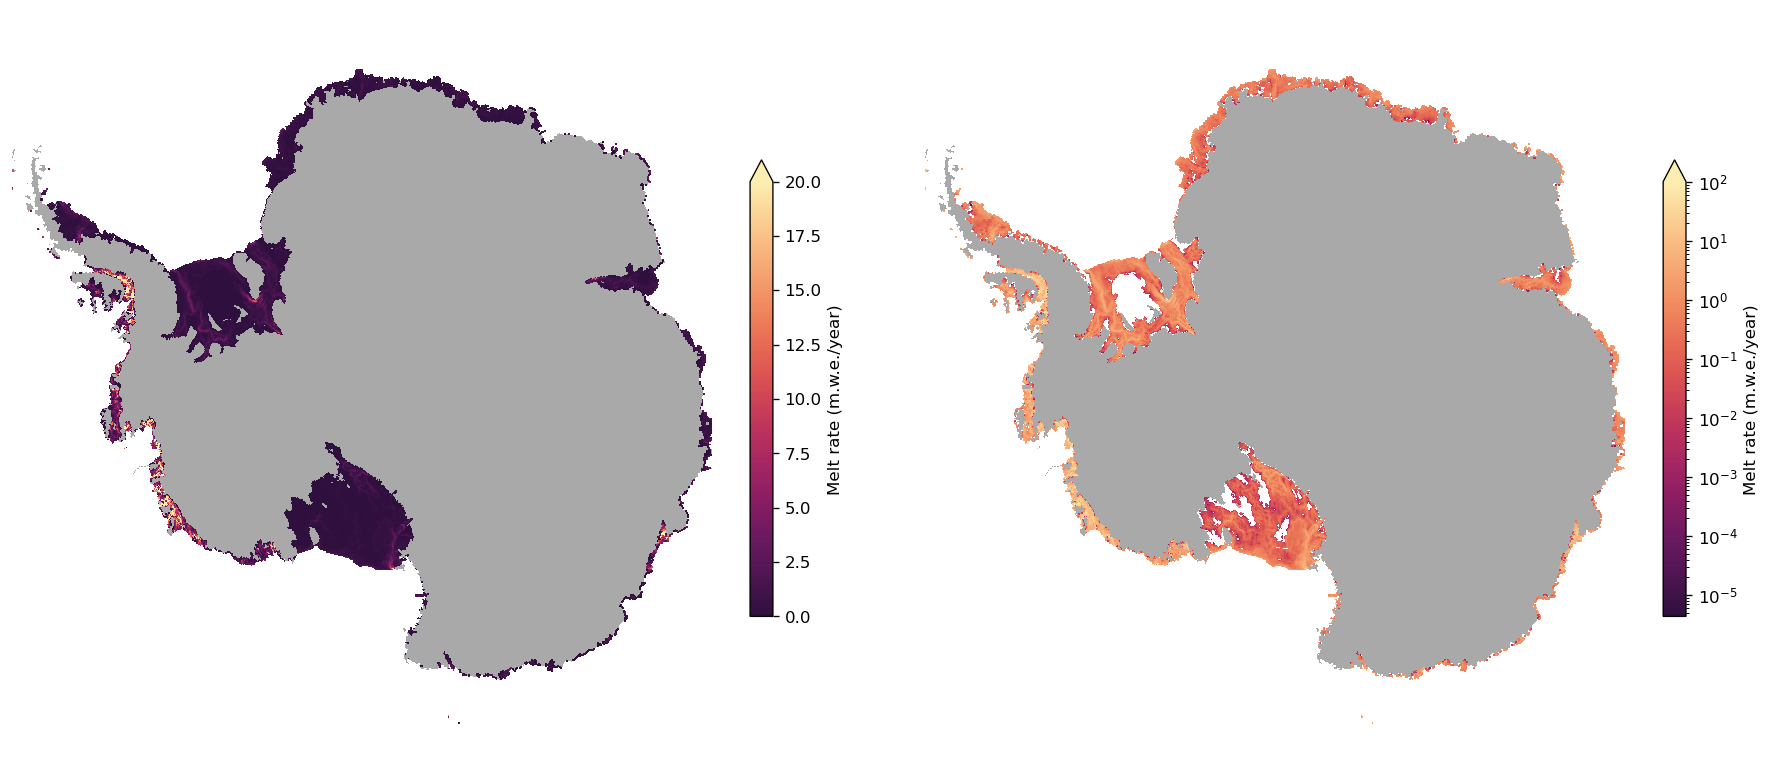

In [16]:
fig, ax = plt.subplots(1,2, figsize=(18,8), dpi=120)

img1 = circumpolar_plot(melt_rate, nemo_mesh_ds, ax=ax[0], masked=False, make_cbar=False, title='',
                        vmin=0, vmax=20, ctype=cmocean.cm.matter_r, shade_land=True, lat_max=-66)

img2 = circumpolar_plot(melt_rate, nemo_mesh_ds, ax=ax[1], masked=False, make_cbar=False, title='',
                        lognorm=True, ctype=cmocean.cm.matter_r, shade_land=True, lat_max=-66)

img = [img1, img2]
for n, axis in enumerate(ax.ravel()):
    plt.colorbar(img[n], ax=axis, extend='max', label='Melt rate (m.w.e./year)', fraction=0.03)

## Calculate total melt over time (gigatonnes)

In [5]:
def calculate_regional_melt_rate(region_name, nemo_ds, return_name=False, return_mask=False,
                                 domain_cfg='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20250217.nc'):

    # get region mask:
    nemo_domcfg               = xr.open_dataset(domain_cfg).squeeze()
    mask, _, region_full_name = region_mask(region_name, nemo_domcfg, option='cavity', return_name=True)

    # calculate the regional melt rate: in the form of (y, x, month), units of kg/month
    # calculate number of days in months for melt rate:
    days_per_month = [monthrange(nemo_ds.time_counter.dt.year[i].values, nemo_ds.time_counter.dt.month[i].values)[1] for i in range(0,nemo_ds.time_counter.size)]
    nemo_ds        = nemo_ds.assign({'days_per_month':(('time_counter'), days_per_month)})
    regional_melt_rate = xr.where(mask.rename({'x':'x_grid_T', 'y':'y_grid_T'})==1,
                                ((nemo_ds.fwfisf)*nemo_ds['days_per_month']*sec_per_day/rho_ice),
                                  np.nan)ERA5_1h_tune0_efr005

    # annual regional melt rate: in the form of (y, x, year), units of gT/year
    annual_regional_melt_rate = regional_melt_rate.resample(time_counter='YE').sum()
    return annual_regional_melt_rate

In [8]:
# annual_getz_melt     = calculate_regional_melt_rate('getz', nemo_ds)
# annual_thwaites_melt = calculate_regional_melt_rate('thwaites', nemo_ds)
# annual_pi_melt       = calculate_regional_melt_rate('pine_island', nemo_ds)
# annual_cosgrove_melt = calculate_regional_melt_rate('cosgrove', nemo_ds)
# annual_abbot_melt    = calculate_regional_melt_rate('abbot', nemo_ds)
annual_EAnt_melt    = calculate_regional_melt_rate('east_antarctica', nemo_ds)

In [17]:
print(annual_getz_melt.where(annual_getz_melt!=0).mean(dim=['x_grid_T','y_grid_T']).mean().values)
print(annual_thwaites_melt.where(annual_thwaites_melt!=0).mean(dim=['x_grid_T','y_grid_T']).mean().values)
print(annual_pi_melt.where(annual_pi_melt!=0).mean(dim=['x_grid_T','y_grid_T']).mean().values)
print(annual_cosgrove_melt.where(annual_cosgrove_melt!=0).mean(dim=['x_grid_T','y_grid_T']).mean().values)
print(annual_abbot_melt.where(annual_abbot_melt!=0).mean(dim=['x_grid_T','y_grid_T']).mean().values)

13.574665326504126
16.702419296535584
14.143539486048986
12.739540845830335
5.9795924801693126


In [13]:
nemo_domcfg = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc').squeeze()
nemo_ds = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/output/ERA5_test6/files/eANT025.L121_1m_19790101_19791231_grid_T.nc')[['area_grid_T']]

for region in ['ross','filchner_ronne','getz','thwaites','pine_island', 'cosgrove', 'abbot', 'amery']:
    mask, _ = region_mask(region, nemo_domcfg, option='cavity')
    area_masked = xr.where(mask.rename({'x':'x_grid_T', 'y':'y_grid_T'})==1, nemo_ds.area_grid_T, np.nan)
    print(f'{region} area: {area_masked.sum().values*1e-6:.0f} km2')

ross area: 504872 km
filchner_ronne area: 455489 km
getz area: 39853 km
thwaites area: 3954 km
pine_island area: 6901 km
cosgrove area: 3614 km
abbot area: 39912 km
amery area: 58834 km


Areas in Adsummilli et al.
Abbot: 		27461
Cosgrove: 	2964
Pine Island: 	5950
Thwaites: 	3352
Crosson		2932
Getz		32114
Ross		358068
Amery		60228
Filchner-ronne	395271

In [ ]:
# convert m. w. e/year --> gT/year
# m/year * (kg/m3) --> kg/year/m2 * area (m2) = kg/year

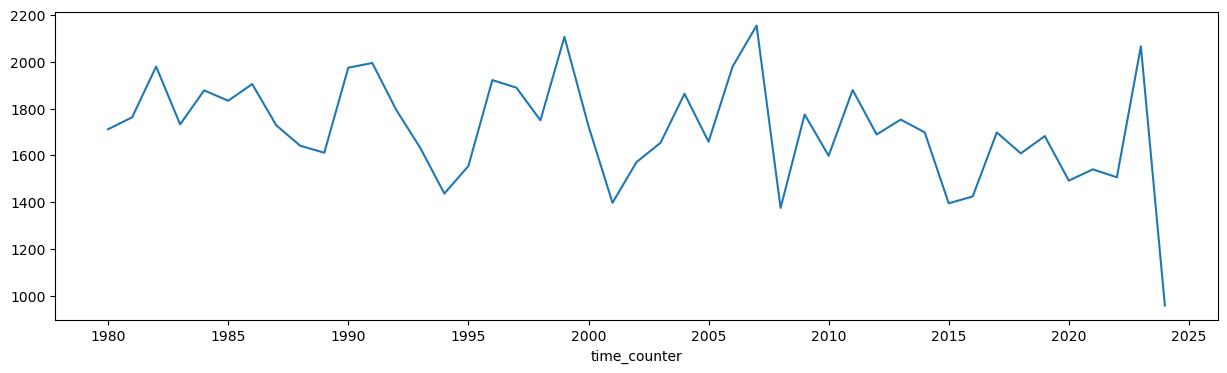

In [21]:
annual_EAnt_melt.isel(x_grid_T=slice(1000,1400)).sum(dim=['x_grid_T','y_grid_T']).plot(figsize=(15,4))

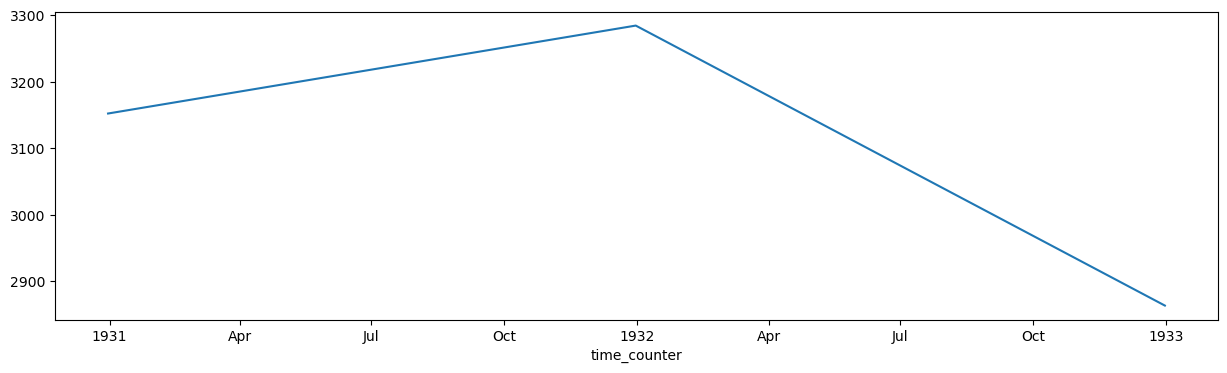

In [31]:
annual_EAnt_melt_cesm2.isel(x_grid_T=slice(1000,1400)).sum(dim=['x_grid_T','y_grid_T']).plot(figsize=(15,4))

In [30]:
gridT_files2     = glob.glob(f'{base_dir}output/CESM2_3hwind_PSL_1930/files0/*SBC*')
nemo_ds2         = xr.open_mfdataset(gridT_files2) 
days_per_month   = [monthrange(nemo_ds2.time_counter.dt.year[i].values, nemo_ds2.time_counter.dt.month[i].values)[1] for i in range(0,nemo_ds2.time_counter.size)]
nemo_ds2         = nemo_ds2.assign({'days_per_month':(('time_counter'), days_per_month)})
annual_EAnt_melt_cesm2 = calculate_regional_melt_rate('east_antarctica', nemo_ds2)

In [18]:
annual_melt_rate = ((nemo_ds.area_grid_T*nemo_ds.fwfisf)*nemo_ds['days_per_month']*sec_per_day).resample(time_counter='YE').sum()*1e-12 # kg/m2/s --> kg/s

/opt/jaspy/lib/python3.11/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


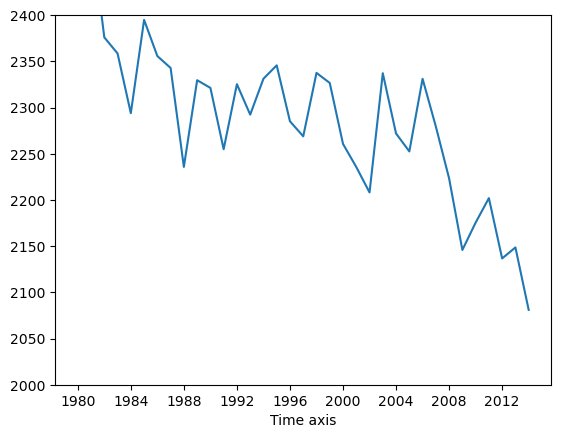

In [19]:
annual_melt_rate.sum(dim=['x_grid_T','y_grid_T']).plot(ylim=(2000,2400))

### Separate melt rate by region

In [27]:
annual_all_melt = calculate_regional_melt_rate('all', nemo_ds)
annual_west_melt = calculate_regional_melt_rate('west_antarctica', nemo_ds)
annual_east_melt = calculate_regional_melt_rate('east_antarctica', nemo_ds)

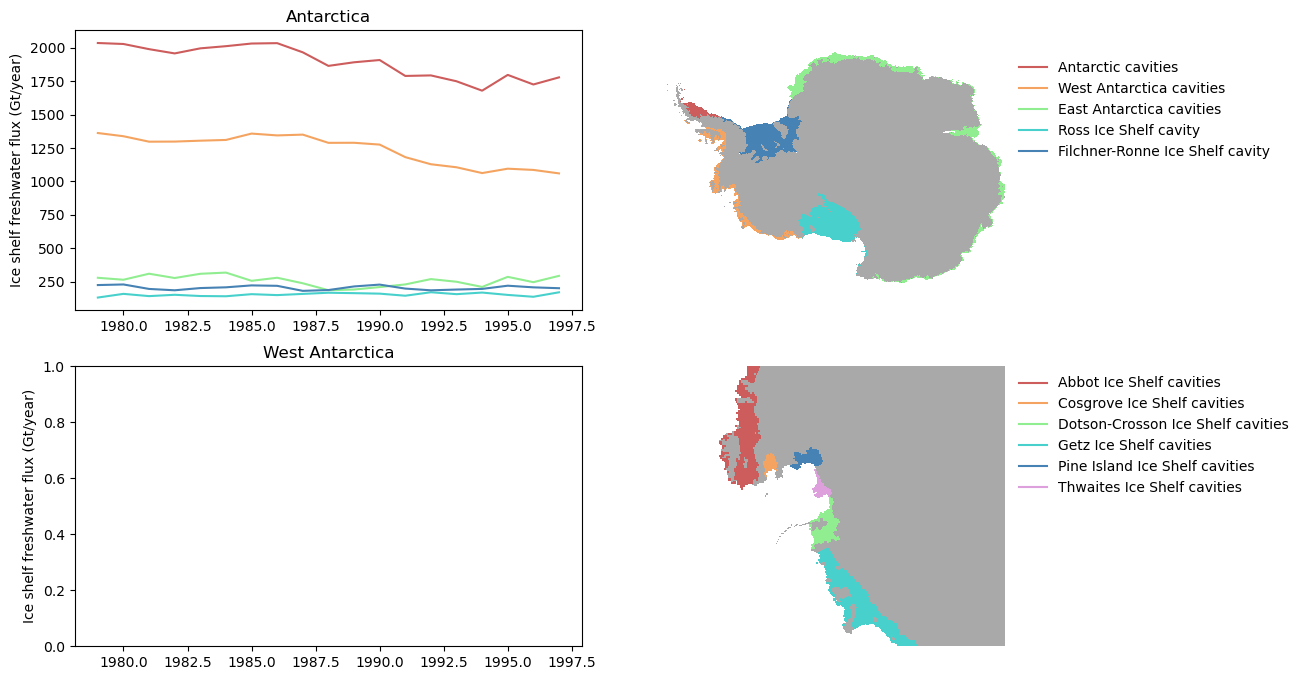

In [10]:
plot_annual_melt_overview(gridT_files, domain_cfg='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20250715.nc',
                          mesh_mask='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20250715.nc')

/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy

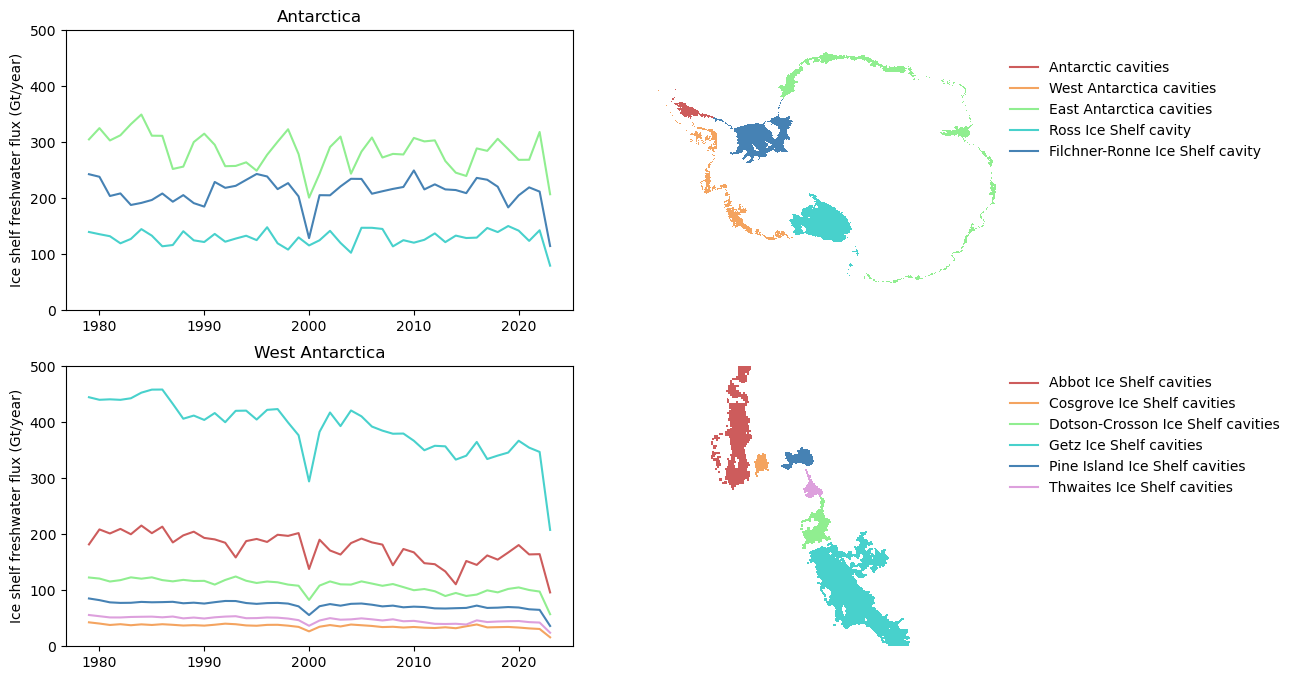

In [9]:
plot_annual_melt_overview(gridT_files, ylim=(0, 500), 
                          domain_cfg='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20250715-shallow-getz.nc',
                          mesh_mask='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20250715-shallow-getz.nc')

/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy

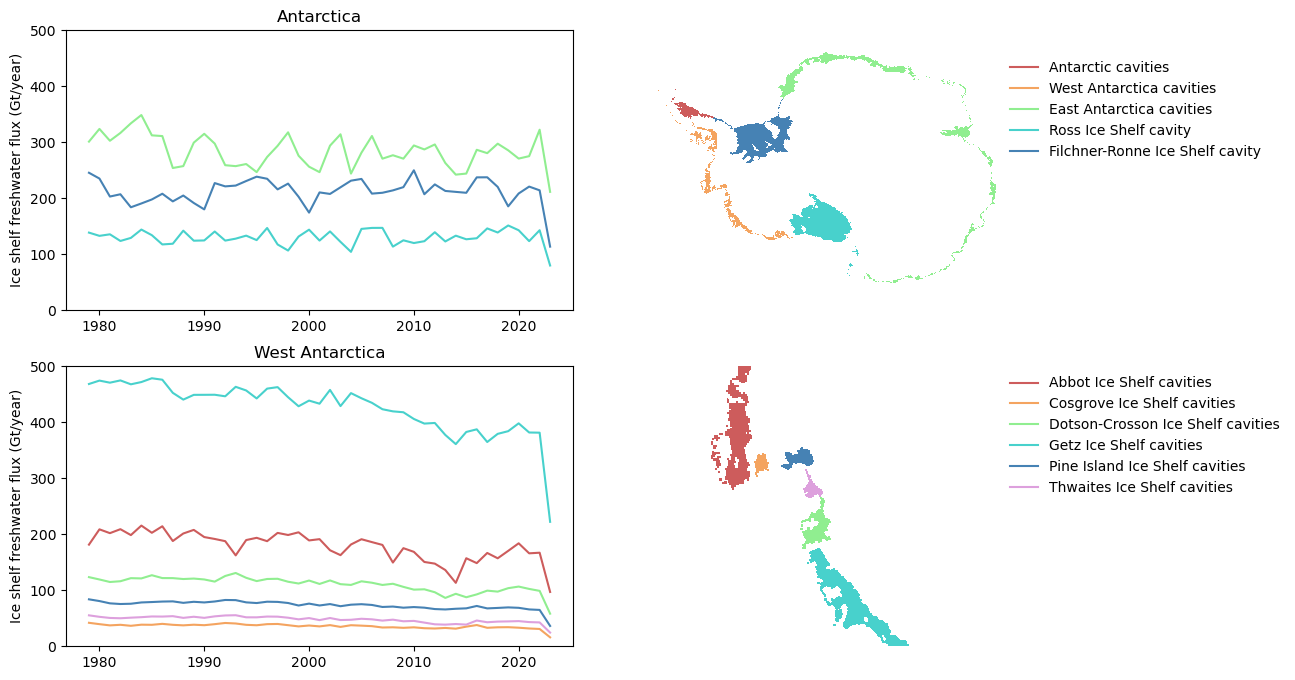

In [14]:
plot_annual_melt_overview(gridT_files, ylim=(0, 500), 
                          domain_cfg='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20250715.nc',
                          mesh_mask='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20250715.nc')

/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.12/site-packages/xarray/groupers.py:509: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy

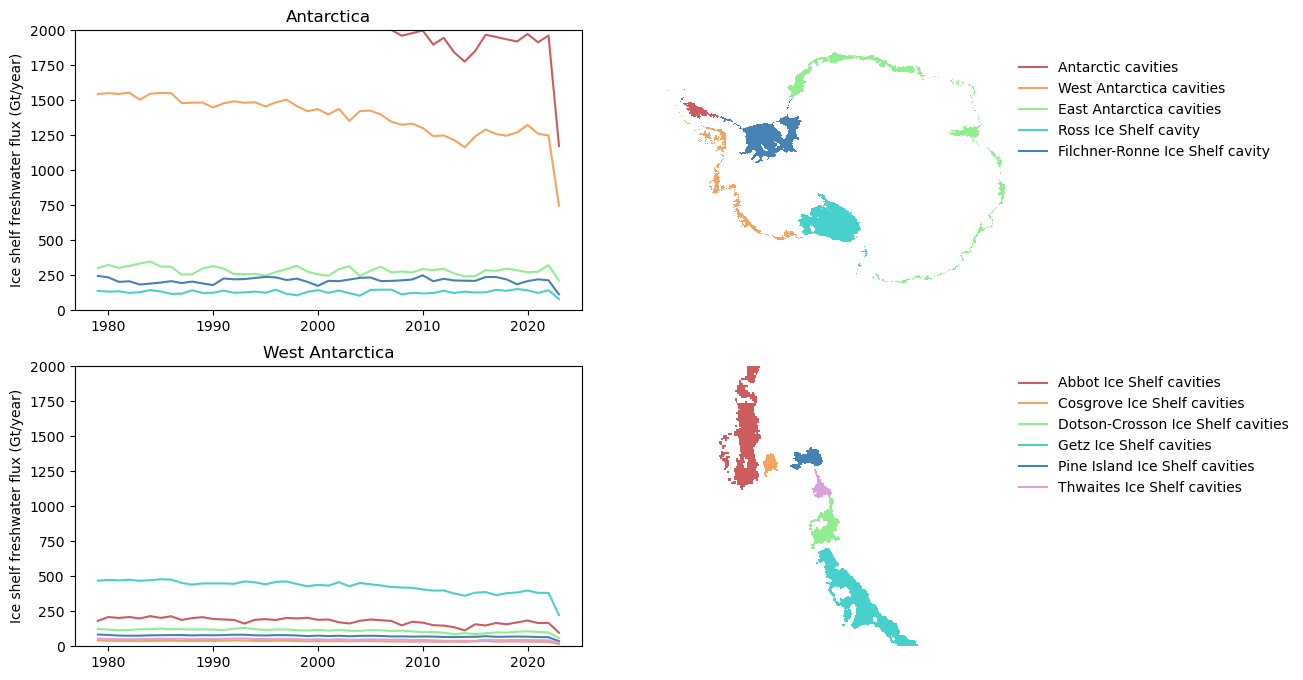

In [15]:
plot_annual_melt_overview(gridT_files, ylim=(0, 2000), 
                          domain_cfg='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20250715.nc',
                          mesh_mask='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20250715.nc')

/opt/jaspy/lib/python3.11/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.11/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.11/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.11/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy/lib/python3.11/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/opt/jaspy

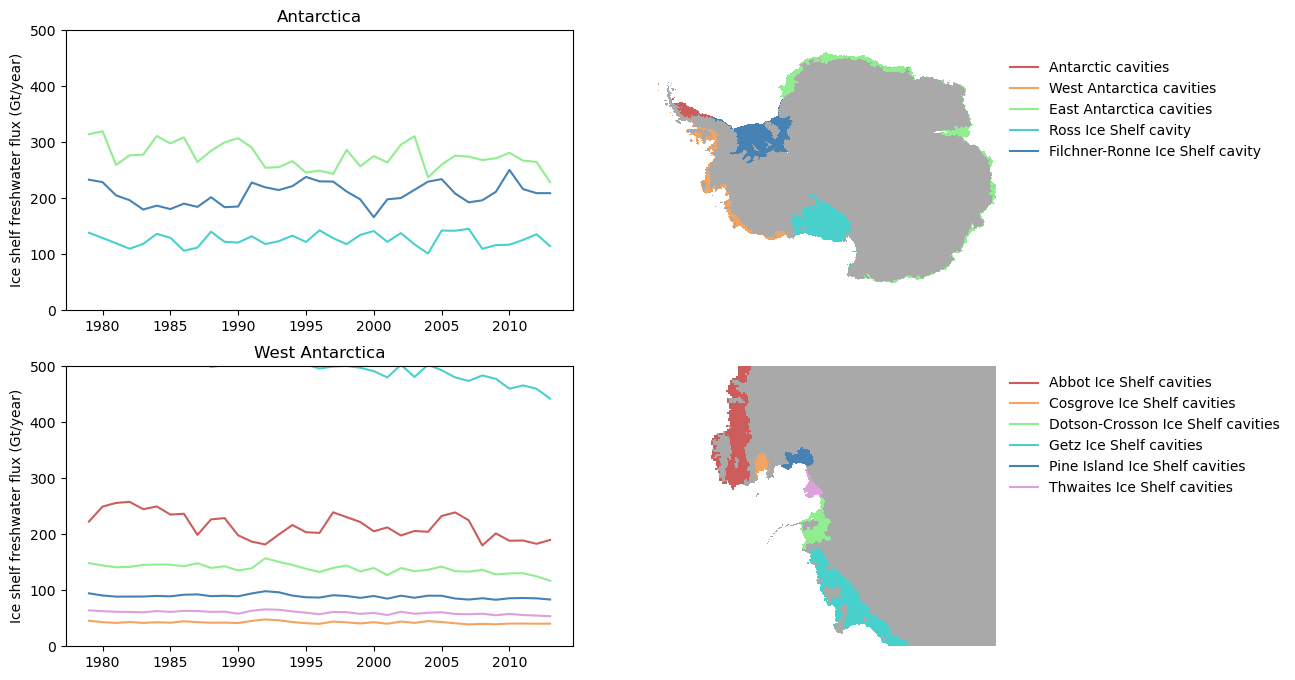

In [28]:
plot_annual_melt_overview(gridT_files, ylim=(0, 500))

In [8]:
colors = ['IndianRed', 'SandyBrown', 'LightGreen', 'MediumTurquoise', 'SteelBlue', 'Plum', 'Pink']
mesh_mask ='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20250217.nc'
nemo_meshmask = xr.open_dataset(mesh_mask).squeeze()

##### Double check masking

In [9]:
nemo_domcfg = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20250217.nc').squeeze()
mask0, _, region_name = region_mask('all', nemo_domcfg, option='cavity', return_name=True)
mask1, _, region_name = region_mask('west_antarctica', nemo_domcfg, option='cavity', return_name=True)
mask2, _, region_name = region_mask('east_antarctica', nemo_domcfg, option='cavity', return_name=True)
not_in_mask = xr.where((mask0.rename({'x':'x_grid_T', 'y':'y_grid_T'})==0)*(nemo_ds.fwfisf.isel(time_counter=0) != 0)*(~np.isnan(nemo_ds.fwfisf.isel(time_counter=0))),
                       1, 0)

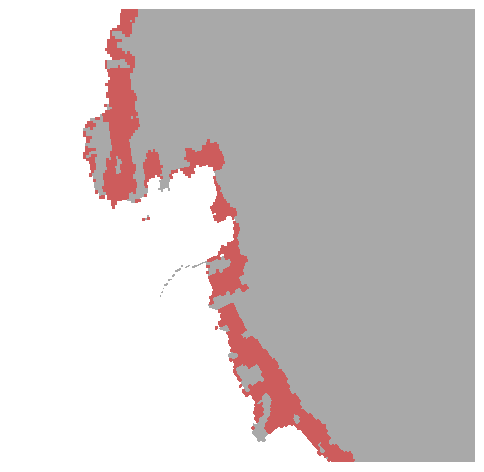

In [9]:
fig, ax = plt.subplots(1,1, figsize=(6,6), dpi=100)

kwags = {'masked':False, 'make_cbar':False, 'title':''}

img1 = circumpolar_plot(mask0, nemo_meshmask, ax=ax, ctype=colors[0], shade_land=True, zoom_amundsen=True, **kwags)

In [6]:
# from nemo_python_git.constants import region_edges, region_edges_flag, region_names, region_points
# from nemo_python_git.utils import remove_disconnected, closest_point
from nemo_python_git.grid import build_shelf_mask, build_ice_mask

In [37]:
ds = nemo_domcfg.copy()
mask, ds     = build_shelf_mask(ds)
shelf_lat=-58 # from NEMO constants
shelf_depth=3000

bathy = ds['bathy_metry'].squeeze()
ocean_mask = xr.where(ds['bottom_level']>0, 1, 0).squeeze()
# # Apply lat-lon bounds and bathymetry bound to ocean mask
mask = ocean_mask*(ds['nav_lat'] <= shelf_lat)*(bathy <= shelf_depth)
# Remove disconnected seamounts
# point0 = closest_point(ds, shelf_point0)
# mask.data = remove_disconnected(mask, point0)

ice_mask, ds = build_ice_mask(ds)
mask *= ice_mask

the mask misses cells because of the cutoff depth in constants.py --- I guess my larger domain contains a few ice shelf cavities that are very deep relative to the regional configuration. Need to figure out a way to generalize this in the code so that the system still works for Kaitlin. Also don't want to deepen what is defined as shelf for everything else.

In [38]:
not_in_mask2 = xr.where((mask==0)*(nemo_ds.fwfisf.isel(time_counter=0).values != 0)*(~np.isnan(nemo_ds.fwfisf.isel(time_counter=0).values)),\
                        1, 0)

In [39]:
sum(sum(not_in_mask2)) 

<xarray.DataArray ()>
array(0)
Coordinates:
    time_counter  float32 0.0

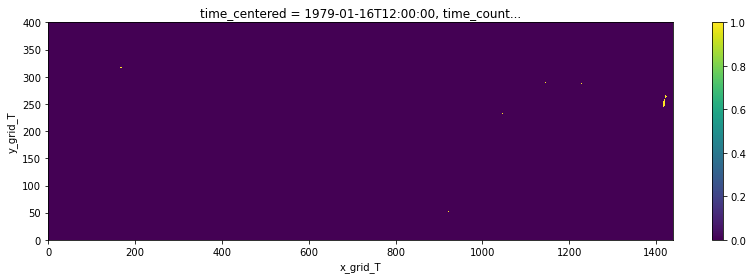

In [66]:
not_in_mask.plot(figsize=(14,4), ylim=(0,400))

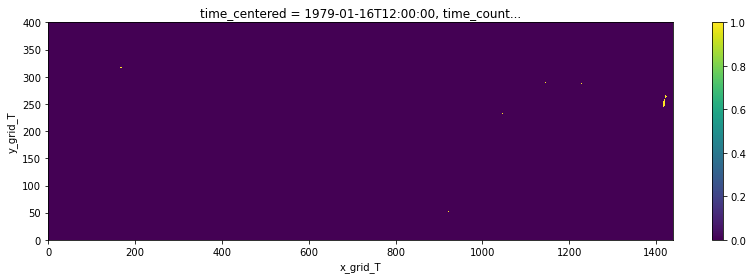

In [41]:
not_in_mask.plot(figsize=(14,4), ylim=(0,400))

Mask doesn't quite seem to include all points that are ice shelf! Need to fix

In [ ]:
# Check that the observations depth is close enough to the bottom bathymetry to be considered representative

# Select the NEMO variables we need and time-average    
lon_land, lat_land, land_plt = plot_land(mesh_sub, mesh_sub.bathy_metry)

#------------- Plot figure -----------------
fig, ax = plt.subplots(1,2, figsize=(10,4), subplot_kw={'projection': ccrs.Mercator(latitude_true_scale=-70)}, dpi=120)

ax.set_extent([-95, -135, -76, -71], ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True);
gl.xlines=None; gl.ylines=None; gl.top_labels=None; gl.right_labels=None;

# kg/m2/s / kg/m3 --> m/s *sec_per_year --> m / year
lon_plt, lat_plt, var_plt = mask_land(mesh_sub, melt_rate_sub)
img = ax.pcolormesh(lon_plt, lat_plt, var_plt, transform=ccrs.PlateCarree(), rasterized=True, vmin=0, vmax=60, cmap=cmocean.cm.matter_r)
ax.pcolormesh(lon_land, lat_land, land_plt, transform=ccrs.PlateCarree(), rasterized=True, cmap=cl.ListedColormap(['DarkGrey']), zorder=3)
plt.colorbar(img, ax=ax, extend='max', label='m of water equivalent / year')